### Transformata Hougha w przestrzeni ab - Domowe

In [35]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
import os
import requests
import math
import random

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/11_Hough/"

fileNames = ["dom.png", "kwadraty.png", "lab112.png"]
for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, "wb").write(r.content)

Przestrzeń ρ,θ nie jest jedyną przestrzenią w której punkt odpowiada parametrom prostej. Np. można spróbować wykorzystać tradycyjne równanie prostej:

$ y = ax+b $

W tej przestrzeni reprezentacją pęku prostych jest prosta. 

Zadanie: napisać funkcję, która jako argument przyjmuje obraz (binarny) oraz parametry:

- aMin - minimalna wartość parametru a
- aMax - maksymalna  wartość parametru a
- aSkok - skok parametru a
- bMin - minimalna wartość parametru b
- bMax  - maksymalna  wartość parametru b
- bSkok - skok parametru b
Jako wynik ma zwrócić macierz przestrzeni Hougha ab.

Uwagi:

- zadanie może wyglądać na skomplikowane ale tak na prawdę wymaga tylko starannego przemyślenia
- najważniejszy jest problem "adresowania" macierzy H. Można do tego wykorzystać dwa wektory A i B ze wszystkimi możliwymi wartościami jakie parametry a i b mogę przyjąć (w podanych zakresach z podanym skokiem). Wówczas indeksy tych wektorów będą współrzędnymi w macierzy H. Do stworzenia wektorów wykorzystaj funkcję _np.arange_
- na podstawie rozmiaru wektorów A i B (własność _shape_) należy stworzyć wyzerowaną macierz H (funkcja _np.zeros_)
- dla każdego punktu krawędzi na obrazie należy:
    - używająć wektora A dla każdej z jego wartości a obliczyć odpowiednią wartość b - indeksy kolejnych wartości a (a_idx) będą jedną z współrzędnych macierzy H, natomiast drugą współrędną mozna uzyskać jako b_idx = np.argmin(abs(B - b)).
        - każde a_idx i b_idx wyznaczą punkt w macierzy H, który należy zinkrementować

In [16]:
def hough_ab_space(
    image,
    a_min: float,
    a_max: float,
    a_delta: float,
    b_min: float,
    b_max: float,
    b_delta: float,
):
    def theta(a: float) -> float:
        return -math.atan(1 / a) if a != 0 else math.pi / 2

    def distance(a: float, b: float) -> float:
        return b * math.sin(theta(a))

    a_values = np.arange(a_min, a_max, step=a_delta)
    b_values = np.arange(b_min, b_max, step=b_delta)[::-1]

    thetas = np.array([theta(a) for a in a_values])
    hough_space, thetas, distances = hough_line(image, thetas)

    height = len(b_values)
    width = len(a_values)
    ab_space = np.zeros(shape=(height, width))

    for y, b in enumerate(b_values):
        for x, a in enumerate(a_values):
            theta_index = x
            distance_index = np.argmin(abs(distances - distance(a, b)))

            ab_space[y, x] = hough_space[distance_index, theta_index]

    return ab_space, a_values, b_values

- działanie funkcji należy przetestować na punktach generowanych w 'edytorku' z punktu "Transformacja Hougha dla małej liczby punktów". Proponowane parametry funkcji:
    - aMin: -5
    - aMax:  5
    - aSkok: 0.05 
    - bMin: -100
    - bMax:  100
    - bSkok: 1

In [17]:
def get_single_point_image(
    coordinates: list[tuple[int, int]], shape: tuple[int, int] = (64, 64)
):
    result = np.zeros(shape, dtype=np.uint8)
    for y, x in coordinates:
        result[y, x] = 1

    return result


def plot_ab_hough(ax, hough_transform_image, a_values, b_values):
    SHOW_X_VALUES = 8
    x_ticks = np.linspace(a_values[0], a_values[-1], num=SHOW_X_VALUES)
    x_tick_positions = np.linspace(0, len(a_values), num=SHOW_X_VALUES)

    y_ticks = np.linspace(b_values[0], b_values[-1], num=SHOW_X_VALUES)
    y_tick_positions = np.linspace(0, len(b_values), num=SHOW_X_VALUES)

    ax.imshow(hough_transform_image, "gray")
    ax.set_title("Hough transform")
    ax.set_xlabel("a")
    ax.set_ylabel("b")
    ax.axis("image")

    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels([f"{val:.2f}" for val in x_ticks])

    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels([f"{round(val)}" for val in y_ticks])

    height, width = hough_transform_image.shape
    ax.set_aspect(width / height, adjustable="box")

    plt.show()


def show_grayscale_image(ax, image, title=None):
    ax.axis("off")
    ax.imshow(image, cmap="gray")
    ax.set_title(title)

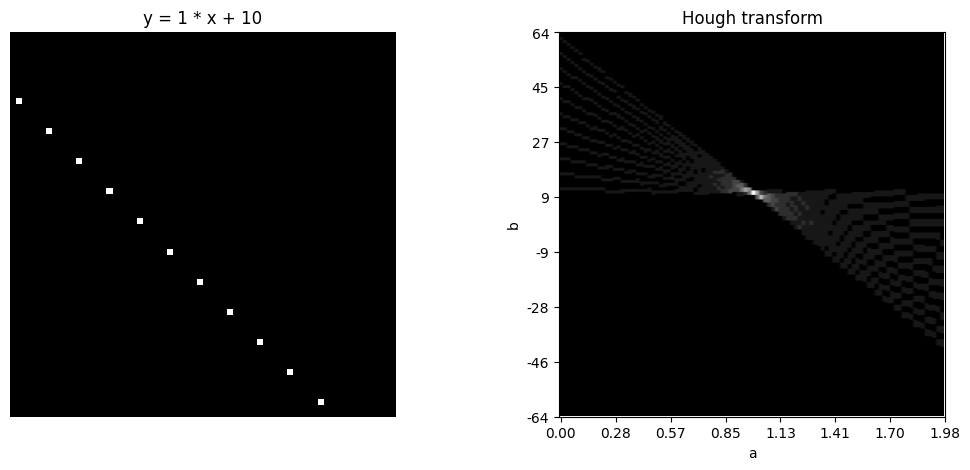

In [18]:
image = get_single_point_image(coordinates=[(r + 10, r) for r in range(1, 52, 5)])

ab_space_image, a_values, b_values = hough_ab_space(
    image, a_min=0, a_max=2, a_delta=0.02, b_min=-64, b_max=64, b_delta=0.5
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))

show_grayscale_image(ax1, image, title="y = 1 * x + 10")
plot_ab_hough(ax2, ab_space_image, a_values, b_values)

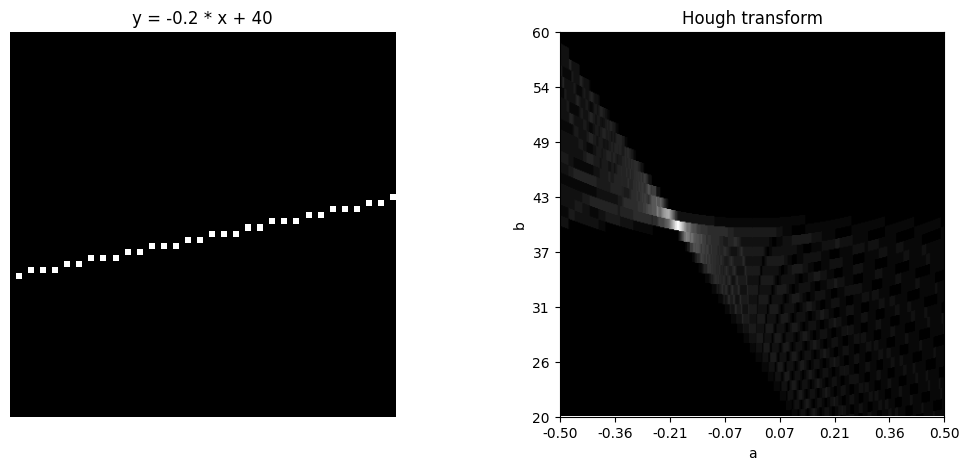

In [33]:
image = get_single_point_image(
    coordinates=[(round(40 - 0.2 * r), r) for r in range(1, 64, 2)]
)

ab_space_image, a_values, b_values = hough_ab_space(
    image, a_min=-0.5, a_max=0.5, a_delta=0.001, b_min=20, b_max=60, b_delta=0.1
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))

show_grayscale_image(ax1, image, title="y = -0.2 * x + 40")
plot_ab_hough(ax2, ab_space_image, a_values, b_values)

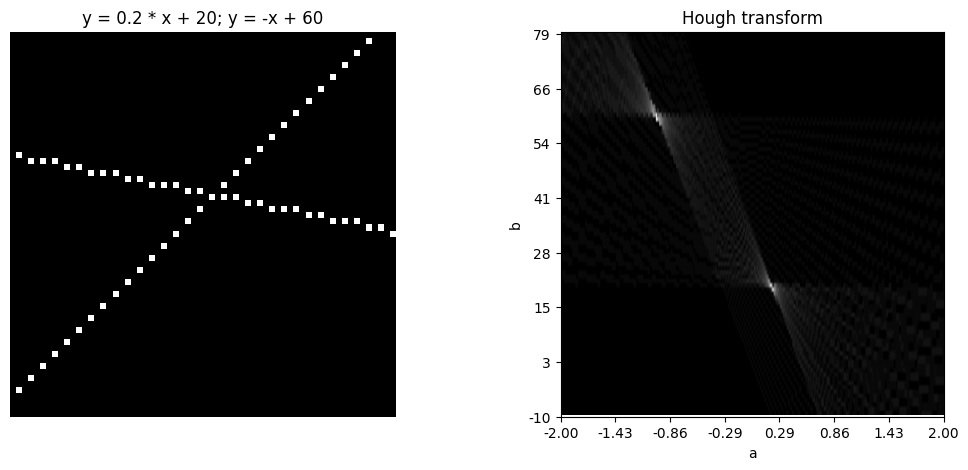

In [64]:
image = get_single_point_image(
    coordinates=[(round(0.2 * r + 20), r) for r in range(1, 64, 2)]
    + [(round(-r + 60), r) for r in range(1, 60, 2)]
)

ab_space_image, a_values, b_values = hough_ab_space(
    image, a_min=-2, a_max=2, a_delta=0.001, b_min=-10, b_max=80, b_delta=1
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))

show_grayscale_image(ax1, image, title="y = 0.2 * x + 20; y = -x + 60")
plot_ab_hough(ax2, ab_space_image, a_values, b_values)

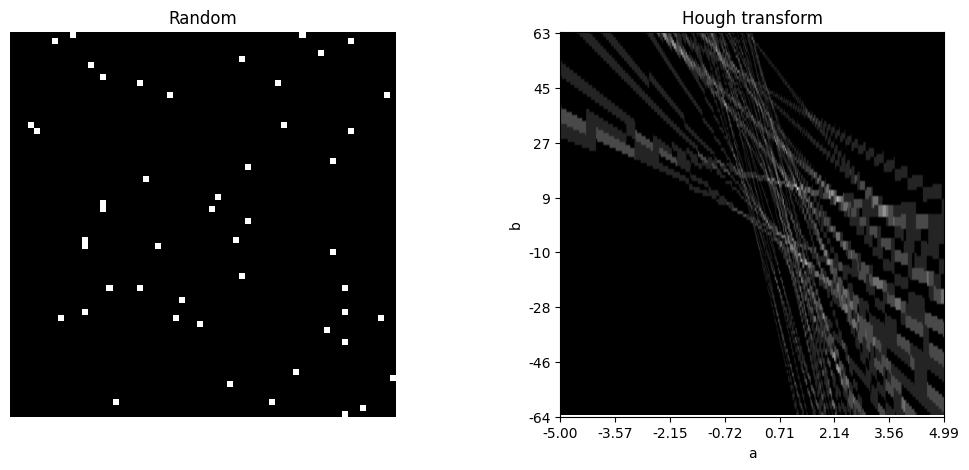

In [42]:
image = get_single_point_image(
    coordinates=[(random.randrange(0, 64), random.randrange(0, 64)) for _ in range(50)]
)

ab_space_image, a_values, b_values = hough_ab_space(
    image, a_min=-5, a_max=5, a_delta=0.01, b_min=-64, b_max=64, b_delta=1
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))

show_grayscale_image(ax1, image, title="Random")
plot_ab_hough(ax2, ab_space_image, a_values, b_values)

Zastanów się w przypadku jakich prostych reprezentacja ab nie sprawdzi się.

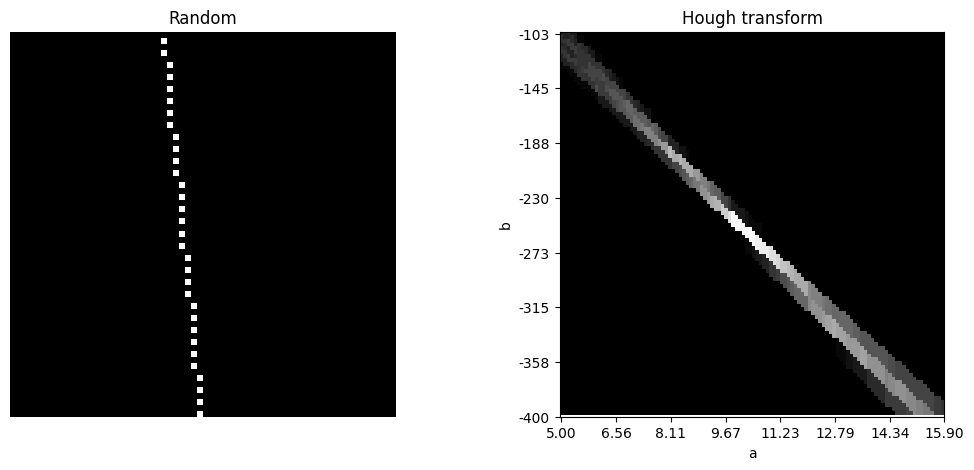

In [54]:
image = get_single_point_image((r, round(r / 10 + 25)) for r in range(1, 64, 2))

ab_space_image, a_values, b_values = hough_ab_space(
    image, a_min=5, a_max=16, a_delta=0.1, b_min=-400, b_max=-100, b_delta=3
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))

show_grayscale_image(ax1, image, title="y = 10x - 250")
plot_ab_hough(ax2, ab_space_image, a_values, b_values)

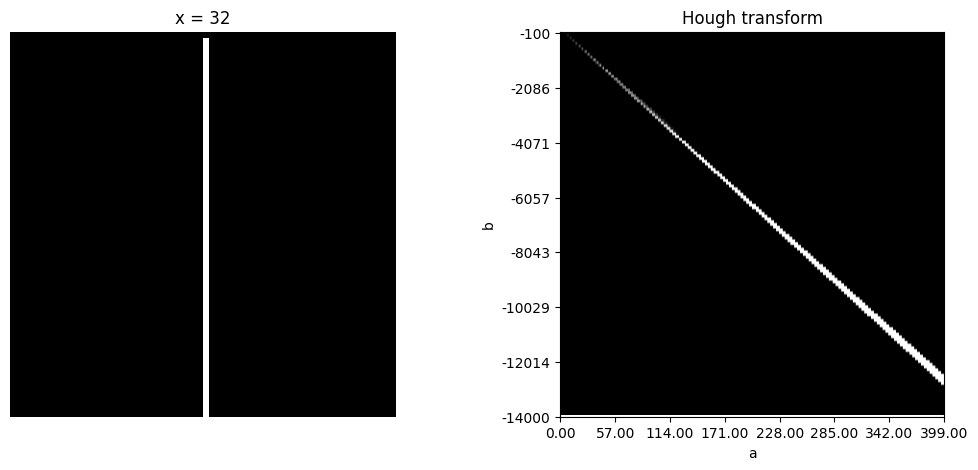

In [62]:
image = get_single_point_image((r, 32) for r in range(1, 64, 1))

ab_space_image, a_values, b_values = hough_ab_space(
    image, a_min=0, a_max=400, a_delta=1, b_min=-14_000, b_max=-0, b_delta=100
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))

show_grayscale_image(ax1, image, title="x = 32")
plot_ab_hough(ax2, ab_space_image, a_values, b_values)